## Machine Learning Conclusion
### 1) Best result with shallow or deep (2 hidden layers) neural network (177 inputs, relu or tanh activation functions with linear output)
### 2) 1 or 2 hidden layers have comparable R-squared values (~0.6 test, ~0.9 train [overfitting is present]); 3 layers yields very poor performance

## Connect to SQLite database

In [1]:
# imports for machine learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# imports for database connection
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func

# import these to view table column headers & rows
from sqlalchemy.orm import sessionmaker
from sqlalchemy import select

In [5]:
engine = create_engine("sqlite:///../resources/mobility_db.db")

In [6]:
# reflect an existing database into a new model (creates base class for automap schema)
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
Base.classes.keys()

['mobility_tbl']

In [8]:
# save references to each table
mobility = Base.classes.mobility_tbl

In [9]:
# Create session (link) from Python to the database
session = sessionmaker(bind=engine)()

# View table column headers & rows
mobility_table = select('*').select_from(mobility)
mobility_result = session.execute(mobility_table).fetchall()
print(mobility.__table__.columns.keys())
# print(mobility_result)

['index', 'date', 'province', 'retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'TotalCases', 'DailyTotals', 'TotalDeaths', 'DailyDeaths', 'TotalRecovered', 'DailyRecovered', 'population']


In [10]:
# perform a query to retrieve the data
results = session.query(mobility.index,mobility.date,mobility.province,mobility.retail_and_recreation,mobility.grocery_and_pharmacy,mobility.parks,mobility.transit_stations,mobility.workplaces,mobility.residential,mobility.DailyTotals).all()

# save the query results as a Pandas DataFrame and set the index
df = pd.DataFrame(results, columns=['index','date', 'province', 'retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'DailyTotals'])
df.set_index(df['index'], inplace=True)

# sort the dataframe by index
df = df.sort_index()

/Users/patricialan/opt/anaconda3/envs/mltensor/lib/python3.7/site-packages/sqlalchemy/sql/sqltypes.py:668: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  "storage." % (dialect.name, dialect.driver)


## Correlate mobility, provinces, date vs daily totals (of covid cases) per province

In [11]:
# preview df
df

,index,date,province,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,DailyTotals
index,,,,,,,,,,
0,0,2020-02-15,ALBERTA,7.0000000000,3.0000000000,24.0000000000,7.0000000000,-2.0000000000,-1.0000000000,0
1,1,2020-02-15,BRITISH COLUMBIA,1.0000000000,0E-10,-4.0000000000,2.0000000000,-4.0000000000,0E-10,0
2,2,2020-02-15,MANITOBA,5.0000000000,2.0000000000,20.0000000000,1.0000000000,1.0000000000,0E-10,0
3,3,2020-02-15,NEW BRUNSWICK,-3.0000000000,-7.0000000000,-13.0000000000,11.0000000000,-3.0000000000,1.0000000000,0
4,4,2020-02-15,NEWFOUNDLAND AND LABRADOR,-1.0000000000,-2.0000000000,-16.0000000000,-1.0000000000,-1.0000000000,1.0000000000,0
...,...,...,...,...,...,...,...,...,...,...
1401,1401,2020-07-25,NEWFOUNDLAND AND LABRADOR,-8.0000000000,4.0000000000,228.0000000000,4.0000000000,0E-10,-3.0000000000,0
1402,1402,2020-07-25,NOVA SCOTIA,-15.0000000000,-10.0000000000,327.0000000000,-23.0000000000,-7.0000000000,0E-10,0
1403,1403,2020-07-25,ONTARIO,-22.0000000000,-3.0000000000,220.0000000000,-31.0000000000,-5.0000000000,2.0000000000,138


In [12]:
# encode provinces
provEnc_df = pd.get_dummies(df['province'])
provEnc_df

,ALBERTA,BRITISH COLUMBIA,MANITOBA,NEW BRUNSWICK,NEWFOUNDLAND AND LABRADOR,NOVA SCOTIA,ONTARIO,QUEBEC,SASKATCHEWAN
index,,,,,,,,,
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1401,0,0,0,0,1,0,0,0,0
1402,0,0,0,0,0,1,0,0,0
1403,0,0,0,0,0,0,1,0,0


In [13]:
# encode dates
dateEnc_df = pd.get_dummies(df['date'])
dateEnc_df

,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,...,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25
index,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# drop columns from df
numFeatures_df = df[['retail_and_recreation','grocery_and_pharmacy', 'parks',\
                     'transit_stations', 'workplaces','residential']]
numFeatures_df

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
index,,,,,,
0,7.0000000000,3.0000000000,24.0000000000,7.0000000000,-2.0000000000,-1.0000000000
1,1.0000000000,0E-10,-4.0000000000,2.0000000000,-4.0000000000,0E-10
2,5.0000000000,2.0000000000,20.0000000000,1.0000000000,1.0000000000,0E-10
3,-3.0000000000,-7.0000000000,-13.0000000000,11.0000000000,-3.0000000000,1.0000000000
4,-1.0000000000,-2.0000000000,-16.0000000000,-1.0000000000,-1.0000000000,1.0000000000
...,...,...,...,...,...,...
1401,-8.0000000000,4.0000000000,228.0000000000,4.0000000000,0E-10,-3.0000000000
1402,-15.0000000000,-10.0000000000,327.0000000000,-23.0000000000,-7.0000000000,0E-10
1403,-22.0000000000,-3.0000000000,220.0000000000,-31.0000000000,-5.0000000000,2.0000000000


In [15]:
# join dfs into monster "features_df"
features_df = numFeatures_df.join([provEnc_df, dateEnc_df], how="inner")
features_df

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,ALBERTA,BRITISH COLUMBIA,MANITOBA,NEW BRUNSWICK,...,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25
index,,,,,,,,,,,,,,,,,,,,,
0,7.0000000000,3.0000000000,24.0000000000,7.0000000000,-2.0000000000,-1.0000000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0000000000,0E-10,-4.0000000000,2.0000000000,-4.0000000000,0E-10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0000000000,2.0000000000,20.0000000000,1.0000000000,1.0000000000,0E-10,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-3.0000000000,-7.0000000000,-13.0000000000,11.0000000000,-3.0000000000,1.0000000000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-1.0000000000,-2.0000000000,-16.0000000000,-1.0000000000,-1.0000000000,1.0000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,-8.0000000000,4.0000000000,228.0000000000,4.0000000000,0E-10,-3.0000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1402,-15.0000000000,-10.0000000000,327.0000000000,-23.0000000000,-7.0000000000,0E-10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1403,-22.0000000000,-3.0000000000,220.0000000000,-31.0000000000,-5.0000000000,2.0000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Machine Learning

In [14]:
# create features(X) and target(y) sets
X = features_df.values

y = df['DailyTotals'].values
y = y.reshape(-1,1)

In [15]:
# create training and testing datasets
# train 95% of data, test 5%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# scale data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Shallow Net (relu, linear): 100 Hidden Neurons

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               17800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 17,901
Trainable params: 17,901
Non-trainable params: 0
_________________________________________________________________
Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 572us/sample - loss: 38518.4913 - mse: 38518.4883
Epoch 2/100
1335/1335 [==============================] - 0s 62us/sample - loss: 37581.6283 - mse: 37581.6328
Epoch 3/100
1335/1335 [==============================] - 0s 63us/sample - loss: 36282.4947 - mse: 36282.4961
Epoch 4/100
1335/1335 [==============================] - 0s 64us/sample - loss: 34461.3790 - mse: 34461.3711
Epoch 5/100
1335/1335 [==============================] 

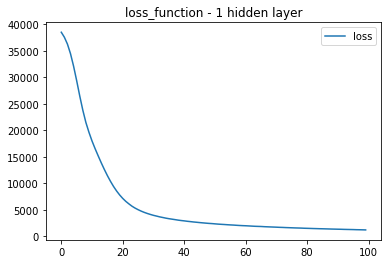

0.9632152153319743
0.6366028210338778


In [16]:
# define model - shallow neural net
number_hidden_nodes = 100
number_input_features = 177

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="relu"))
nn.add(Dense(1, activation="linear"))

nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_1 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

## Shallow Net (relu, linear): 354 Hidden Neurons (2X Features)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 354)               63012     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 355       
Total params: 63,367
Trainable params: 63,367
Non-trainable params: 0
_________________________________________________________________
Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 518us/sample - loss: 38116.7145 - mse: 38116.7148
Epoch 2/100
1335/1335 [==============================] - 0s 78us/sample - loss: 35905.3203 - mse: 35905.3164
Epoch 3/100
1335/1335 [==============================] - 0s 80us/sample - loss: 32444.9881 - mse: 32444.9922
Epoch 4/100
1335/1335 [==============================] - 0s 77us/sample - loss: 27865.9780 - mse: 27865.9766
Epoch 5/100
1335/1335 [==============================

Epoch 71/100
1335/1335 [==============================] - 0s 89us/sample - loss: 758.5378 - mse: 758.5378
Epoch 72/100
1335/1335 [==============================] - 0s 88us/sample - loss: 737.9374 - mse: 737.9375
Epoch 73/100
1335/1335 [==============================] - 0s 89us/sample - loss: 718.3591 - mse: 718.3591
Epoch 74/100
1335/1335 [==============================] - 0s 89us/sample - loss: 701.5671 - mse: 701.5670
Epoch 75/100
1335/1335 [==============================] - 0s 88us/sample - loss: 687.2763 - mse: 687.2764
Epoch 76/100
1335/1335 [==============================] - 0s 89us/sample - loss: 676.2244 - mse: 676.2244
Epoch 77/100
1335/1335 [==============================] - 0s 90us/sample - loss: 659.6669 - mse: 659.6667
Epoch 78/100
1335/1335 [==============================] - 0s 84us/sample - loss: 643.1509 - mse: 643.1508
Epoch 79/100
1335/1335 [==============================] - 0s 85us/sample - loss: 623.5565 - mse: 623.5566
Epoch 80/100
1335/1335 [======================

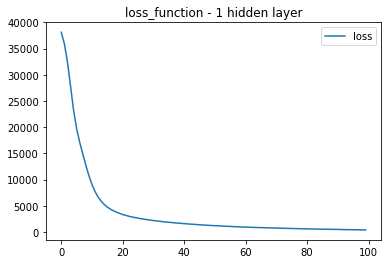

0.9889382616334299
0.6163345598023791


In [17]:
# define model - shallow neural net
number_hidden_nodes = 354
number_input_features = 177

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="relu"))
nn.add(Dense(1, activation="linear"))

nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_2 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_2.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

## Shallow Net (relu, linear): 531 Hidden Neurons (3X Features)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 531)               94518     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 532       
Total params: 95,050
Trainable params: 95,050
Non-trainable params: 0
_________________________________________________________________
Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 501us/sample - loss: 37986.1656 - mse: 37986.1680
Epoch 2/100
1335/1335 [==============================] - 0s 97us/sample - loss: 34980.9378 - mse: 34980.9375
Epoch 3/100
1335/1335 [==============================] - 0s 96us/sample - loss: 30414.7745 - mse: 30414.7676
Epoch 4/100
1335/1335 [==============================] - 0s 96us/sample - loss: 24828.4653 - mse: 24828.4648
Epoch 5/100
1335/1335 [==============================

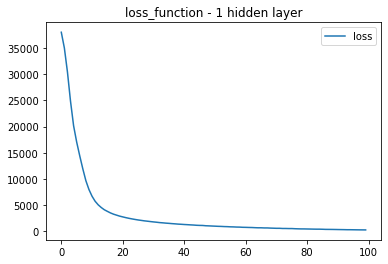

0.9925794000352645
0.628023792969143


In [18]:
# define model - shallow neural net
number_hidden_nodes = 531
number_input_features = 177

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="relu"))
nn.add(Dense(1, activation="linear"))

nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_3 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_3.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

## Shallow Net (tanh, linear): 531 Hidden Neurons (3X Features)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 531)               94518     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 532       
Total params: 95,050
Trainable params: 95,050
Non-trainable params: 0
_________________________________________________________________
Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 567us/sample - loss: 38240.6616 - mse: 38240.6602
Epoch 2/100
1335/1335 [==============================] - 0s 118us/sample - loss: 35792.6829 - mse: 35792.6875
Epoch 3/100
1335/1335 [==============================] - 0s 116us/sample - loss: 32731.0109 - mse: 32731.0078
Epoch 4/100
1335/1335 [==============================] - 0s 137us/sample - loss: 30004.0017 - mse: 30004.0000
Epoch 5/100
1335/1335 [===========================

1335/1335 [==============================] - 0s 131us/sample - loss: 861.0056 - mse: 861.0056
Epoch 71/100
1335/1335 [==============================] - 0s 123us/sample - loss: 819.9382 - mse: 819.9382
Epoch 72/100
1335/1335 [==============================] - 0s 130us/sample - loss: 782.9421 - mse: 782.9421
Epoch 73/100
1335/1335 [==============================] - 0s 124us/sample - loss: 746.9860 - mse: 746.9860
Epoch 74/100
1335/1335 [==============================] - 0s 123us/sample - loss: 717.4680 - mse: 717.4680
Epoch 75/100
1335/1335 [==============================] - 0s 139us/sample - loss: 681.0574 - mse: 681.0574
Epoch 76/100
1335/1335 [==============================] - 0s 123us/sample - loss: 648.1498 - mse: 648.1498
Epoch 77/100
1335/1335 [==============================] - 0s 160us/sample - loss: 621.0753 - mse: 621.0754
Epoch 78/100
1335/1335 [==============================] - 0s 153us/sample - loss: 594.8090 - mse: 594.8090
Epoch 79/100
1335/1335 [==========================

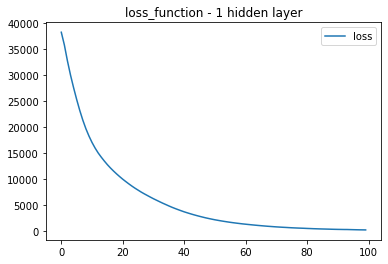

0.9930182732626245
0.598922191424841


In [19]:
# define model - shallow neural net
number_hidden_nodes = 531
number_input_features = 177

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="tanh"))
nn.add(Dense(1, activation="linear"))

nn.summary()

# compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# train model
model_3 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_3.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

## Deep Learning

### relu, relu, linear, 2 layers (160N, 80N)

Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 571us/sample - loss: 37458.6603 - mse: 37458.6562
Epoch 2/100
1335/1335 [==============================] - 0s 87us/sample - loss: 30837.5859 - mse: 30837.5859
Epoch 3/100
1335/1335 [==============================] - 0s 87us/sample - loss: 22986.4845 - mse: 22986.4844
Epoch 4/100
1335/1335 [==============================] - 0s 87us/sample - loss: 18740.4737 - mse: 18740.4707
Epoch 5/100
1335/1335 [==============================] - 0s 85us/sample - loss: 15332.8039 - mse: 15332.8027
Epoch 6/100
1335/1335 [==============================] - 0s 87us/sample - loss: 12612.2070 - mse: 12612.2080
Epoch 7/100
1335/1335 [==============================] - 0s 88us/sample - loss: 10383.3200 - mse: 10383.3203
Epoch 8/100
1335/1335 [==============================] - 0s 88us/sample - loss: 8653.6228 - mse: 8653.6230
Epoch 9/100
1335/1335 [==============================] - 0s 88us/sample - loss: 7221.8819 - mse: 7221.8818


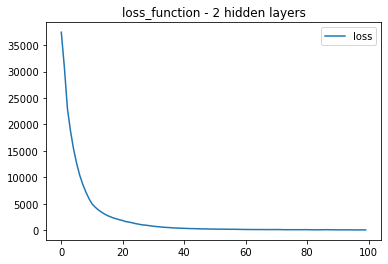

0.9986851145014585
0.6186933280507786


In [20]:
# Define the model - deep neural net
number_input_features = 177
hidden_nodes_layer1 = 160
hidden_nodes_layer2 = 80

nn = Sequential()
# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))
# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_4 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_4.history["loss"])
plt.title("loss_function - 2 hidden layers")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

### tanh, tanh, linear, 2 layers (160N, 80N) [BEST MODEL]

Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 475us/sample - loss: 38460.4640 - mse: 38460.4648
Epoch 2/100
1335/1335 [==============================] - 0s 84us/sample - loss: 37148.7702 - mse: 37148.7695
Epoch 3/100
1335/1335 [==============================] - 0s 85us/sample - loss: 36296.2845 - mse: 36296.2891
Epoch 4/100
1335/1335 [==============================] - 0s 86us/sample - loss: 35730.1440 - mse: 35730.1445
Epoch 5/100
1335/1335 [==============================] - 0s 83us/sample - loss: 35233.4903 - mse: 35233.4883
Epoch 6/100
1335/1335 [==============================] - 0s 88us/sample - loss: 34755.3275 - mse: 34755.3242
Epoch 7/100
1335/1335 [==============================] - 0s 85us/sample - loss: 34283.2459 - mse: 34283.2461
Epoch 8/100
1335/1335 [==============================] - 0s 84us/sample - loss: 33825.7414 - mse: 33825.7422
Epoch 9/100
1335/1335 [==============================] - 0s 83us/sample - loss: 33378.6830 - mse: 33378.6

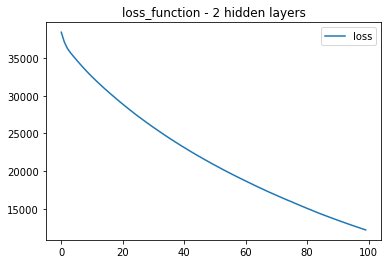

r2 score (train): 0.6270458477440483
r2 score (test): 0.2825470427135851


In [25]:
# Define the model - deep neural net
number_input_features = 177
hidden_nodes_layer1 = 160
hidden_nodes_layer2 = 80

nn = Sequential()
# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="tanh"))
# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_5 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_5.history["loss"])
plt.title("loss_function - 2 hidden layers")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(f'r2 score (train): {r2_score(y_train, y_train_pred)}')
print(f'r2 score (test): {r2_score(y_test, y_test_pred)}')

### tanh, tanh, tanh, linear, 3 layers (160N, 80N, 40N)

Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 594us/sample - loss: 38479.4233 - mse: 38479.4258
Epoch 2/100
1335/1335 [==============================] - 0s 102us/sample - loss: 37521.0240 - mse: 37521.0195
Epoch 3/100
1335/1335 [==============================] - 0s 103us/sample - loss: 37130.5838 - mse: 37130.5898
Epoch 4/100
1335/1335 [==============================] - 0s 101us/sample - loss: 36853.9714 - mse: 36853.9688
Epoch 5/100
1335/1335 [==============================] - 0s 99us/sample - loss: 36602.8669 - mse: 36602.8633
Epoch 6/100
1335/1335 [==============================] - 0s 101us/sample - loss: 36359.3369 - mse: 36359.3359
Epoch 7/100
1335/1335 [==============================] - 0s 102us/sample - loss: 36118.5299 - mse: 36118.5312
Epoch 8/100
1335/1335 [==============================] - 0s 99us/sample - loss: 35878.1459 - mse: 35878.1445
Epoch 9/100
1335/1335 [==============================] - 0s 103us/sample - loss: 35642.8384 - mse: 3

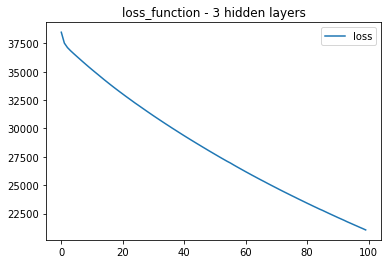

0.35356377950322626
0.14641296901120893


In [23]:
# Define the model - deep neural net
number_input_features = 177
hidden_nodes_layer1 = 160
hidden_nodes_layer2 = 80
hidden_nodes_layer3 = 40

nn = Sequential()
# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="tanh"))
# Third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="tanh"))
# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_6 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_6.history["loss"])
plt.title("loss_function - 3 hidden layers")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

### tanh, tanh, tanh, linear, 3 layers (80N, 40N, 20N)

Train on 1335 samples
Epoch 1/100
1335/1335 [==============================] - 1s 647us/sample - loss: 38693.3748 - mse: 38693.3711
Epoch 2/100
1335/1335 [==============================] - 0s 78us/sample - loss: 38104.6993 - mse: 38104.6992
Epoch 3/100
1335/1335 [==============================] - 0s 78us/sample - loss: 37773.8546 - mse: 37773.8516
Epoch 4/100
1335/1335 [==============================] - 0s 78us/sample - loss: 37596.7134 - mse: 37596.7148
Epoch 5/100
1335/1335 [==============================] - 0s 79us/sample - loss: 37445.6068 - mse: 37445.6094
Epoch 6/100
1335/1335 [==============================] - 0s 79us/sample - loss: 37301.9540 - mse: 37301.9609
Epoch 7/100
1335/1335 [==============================] - 0s 78us/sample - loss: 37166.5793 - mse: 37166.5781
Epoch 8/100
1335/1335 [==============================] - 0s 81us/sample - loss: 37033.2871 - mse: 37033.2891
Epoch 9/100
1335/1335 [==============================] - 0s 80us/sample - loss: 36904.3165 - mse: 36904.3

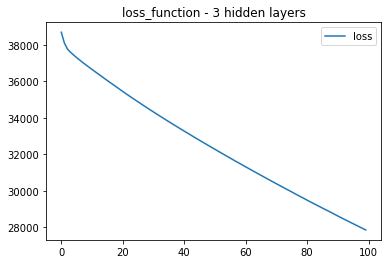

0.14348759911223852
0.05396752581037956


In [24]:
# Define the model - deep neural net
number_input_features = 177
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 40
hidden_nodes_layer3 = 20

nn = Sequential()
# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="tanh"))
# Third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="tanh"))
# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_7 = nn.fit(X_train_scaled, y_train, epochs=100)

# Plot the train and test loss function
plt.plot(model_7.history["loss"])
plt.title("loss_function - 3 hidden layers")
plt.legend(["loss"])
plt.show()

y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))